In [192]:
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import time

In [193]:
# Specify the path to your .txt file
api_path = "../keys/api_key_youtube.txt"

api_key_number = 6

# Get api_key text
with open(api_path, 'r') as file:
    api_key = str(file.read()).split('\n')[api_key_number].split(':')[1].strip()

In [194]:
# Parámetros de la consulta inicial
queries_old = [
    'top smartphones',
    'smartphones gama media',
    'smartphones gaming',
    'unboxing smartphone',
    'smartphones con mejor camara'
]

queries = [
    "What is artificial intelligence?",
    "Artificial intelligence applications in healthcare",
    "AI in autonomous vehicles",
    "Machine learning vs deep learning",
    "Artificial intelligence in finance",
    "How does AI work?",
    "Top AI tools for data science",
    "Artificial intelligence in robotics",
    # "Ethics in artificial intelligence",
    "AI-driven innovation in business",
    # "Future of artificial intelligence in 2024",
    # "How to learn artificial intelligence?",
    # "Natural language processing with AI",
    # "AI in video games development",
    # "AI-powered personal assistants",
    # "AI in cybersecurity",
    # "Artificial intelligence and the job market",
    # "Best AI projects for beginners",
    # "AI startups to watch in 2024",
    # "Impact of AI on education"
]

params = {
    'part': 'snippet',
    'type': 'video',
    'maxResults': 50,
    'key': api_key,
    'order': 'viewCount',
    # 'publishedAfter': '2022-01-01T00:00:00Z',
    'videoDuration': 'any',
    'regionCode': 'US'
}

In [33]:
import requests

def fetch_search_videos(api_key, params, query, max_results=500):

    url = 'https://www.googleapis.com/youtube/v3/search'
    params['q'] = query
    params['maxResults'] = min(max_results, 50)  # Limitar a 50 por solicitud, que es el máximo permitido por la API
    params['key'] = api_key

    response = requests.get(url, params=params)
    all_results = response.json()['items']
    page_info = response.json()['pageInfo']['totalResults']
    print(f'total video results: {page_info}')

    next_page_token = response.json().get('nextPageToken')
    
    # Continuar obteniendo resultados hasta alcanzar el límite deseado
    while next_page_token and len(all_results) < max_results:
        params['pageToken'] = next_page_token
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            results = response.json()
            all_results.extend(results['items'])
            next_page_token = results.get('nextPageToken')
        else:
            print(f"Error: {response.status_code}")
            break

    return all_results[:max_results]

# Get Video Metadata

In [56]:
# Function to fetch video metadata
def fetch_video_metadata(video_id, api_key):
    url = f"https://www.googleapis.com/youtube/v3/videos?part=snippet,statistics,contentDetails&id={video_id}&key={api_key}"
    response = requests.get(url).json()
    if 'items' in response and len(response['items']) > 0:
        return(response['items'])
    else:
        return None

In [197]:
df_video_id = pd.read_csv('../data/raw_data/df_video_search_ids_ai.csv')
video_id_list = set(df_video_id['video_id'])
len(video_id_list)

2927

In [57]:
video_info_test = [fetch_video_metadata(id, api_key) for id in video_id_list]
video_info_test[0]

[{'kind': 'youtube#video',
  'etag': 'Z9ntkPPN08eZdXPUOG8ACiM2yLk',
  'id': 'qtlUwwtvuEg',
  'snippet': {'publishedAt': '2023-05-01T13:00:18Z',
   'channelId': 'UC4ay94l73_FLJ_WJkIqLnSw',
   'title': '2024 Twelve Best free AI tools for Academic Research || Latest AI tools || AI for researchers',
   'description': "#aitools   #researchpaper   #academicwriting #academicwriting #researchtools   #Gurrutechsolutions\n\nLearn how to use Twelve Best free AI tools for Academic Research or 2023 best free AI's for academic research and studies purpose.\n\nTimecodes\n0:00-Intro\n0:50-ChatDoc\n4:01-Explain Paper\n6:59-Humata\n9:48-Elicit\n11:52-Wordtune read\n14:01-Quillbot\n15:46-Spinbot\n16:48-GPT minus 1\n17:54-ChatGPT\n19:31-Paper Digest\n21:07-Citefast\n22:47-Mybib\n\nAbout this Video:-\nIn this video, we'll explore 12 different AI tools that can be useful for academic research. Whether you're a student, a researcher, or an educator, these tools can help you save time and improve the quality 

In [59]:
def get_video_metadata(video_response):
    
    if video_response == None:
        return None
    
    video_metadata = video_response[0]

    if video_metadata and len(video_metadata) > 0:
        video_info = {
                    "videoId": video_metadata['id'],
                    "title": video_metadata['snippet']['title'],
                    "channelId": video_metadata['snippet']['channelId'],
                    "description": video_metadata['snippet']['description'],
                    "publishedAt": video_metadata['snippet']['publishedAt'],
                    "thumbnail_url": video_metadata['snippet']['thumbnails']['default']['url'],
                    "tags": video_metadata['snippet'].get('tags', []),
                    "live_broadcast": video_metadata['snippet']['liveBroadcastContent'],
                    "categoryId": video_metadata['snippet']['categoryId'],
                    "viewCount": video_metadata['statistics'].get('viewCount', 0),
                    "likeCount": video_metadata['statistics'].get('likeCount', 0),
                    "commentCount": video_metadata['statistics'].get('commentCount', 0),
                    "licensed": video_metadata['contentDetails']['licensedContent'],
                    "duration": video_metadata['contentDetails']['duration'],
                    "caption": video_metadata['contentDetails']['caption'],
                    }
        return(video_info)
    else:
        return None   

In [60]:
video_metadata_test = [get_video_metadata(video_info_test[n]) for n in range(0, len(video_id_list))]
len(video_metadata_test)

2927

In [68]:
df_video = pd.DataFrame(video_metadata_test)

In [69]:
from langdetect import detect, DetectorFactory, LangDetectException
from nltk.corpus import stopwords

# Create a column with language detected
def detect_language(text):
    try:
        # Verificar si el texto es lo suficientemente largo
        if len(text.strip()) == 0:
            return None
        # Intentar detectar el idioma
        language = detect(text)
        return language
    except LangDetectException:
        # Si el texto es demasiado corto o no se puede detectar el idioma, devolver None
        return None

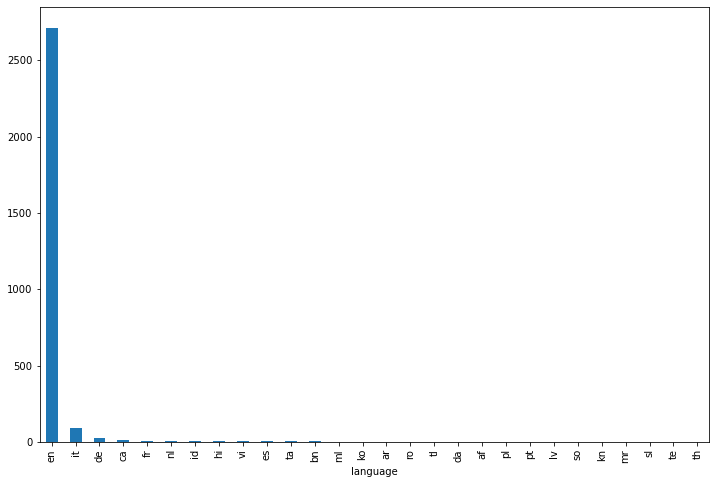

In [72]:
df_video['language'] = df_video['title'].apply(detect_language)

plt.figure(figsize=(12,8))
df_video['language'].value_counts().plot(kind='bar')
plt.show();

In [191]:
df_video.to_csv('../data/raw_data/df_video_ai.csv', index=False)

# Get Video Comments

In [100]:
import requests

def fetch_top_comments(video_id, api_key, total_comments):
    url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    params = {
        'part': 'snippet',
        'videoId': video_id,
        'order': 'relevance',
        'key': api_key
    }
    
    # Determinar el número de comentarios a recuperar según el total de comentarios
    if total_comments <= 100:
        max_comments = total_comments
    elif total_comments <= 1000:
        max_comments = int(total_comments * 0.75)
    elif total_comments <= 10000:
        max_comments = int(total_comments * 0.2)
    else:
        max_comments = int(total_comments * 0.05)
    
    # Limitar a un máximo de 1000 comentarios
    max_comments = min(max_comments, 1000)
    
    # Preparar para recuperar comentarios
    params['maxResults'] = 100  # Máximo permitido por la API en una solicitud
    
    all_comments = []
    next_page_token = None

    while len(all_comments) < max_comments:
        if next_page_token:
            params['pageToken'] = next_page_token

        response = requests.get(url, params=params)
        if response.status_code == 200:
            results = response.json()
            for item in results['items']:
                comment = item['snippet']['topLevelComment']['snippet']
                comment_data = {
                    'comment_id': item['id'],
                    'author': comment['authorDisplayName'],
                    'author_channel_id': comment['authorChannelId']['value'],
                    'text': comment['textDisplay'],
                    'like_count': comment['likeCount'],
                    'published_at': comment['publishedAt'],
                    'updated_at': comment['updatedAt'],
                    'totalReplyCount': item['snippet']['totalReplyCount'],
                    'video_id': video_id
                }
                all_comments.append(comment_data)
            
            next_page_token = results.get('nextPageToken')
            
            if not next_page_token or len(all_comments) >= max_comments:
                break
        else:
            print(f"Error: {response.status_code}")
            break

    return all_comments[:max_comments]

In [101]:
# Clean dataframe 

df_video = df_video[df_video['language'] == 'en'].copy().reset_index()
df_video.drop(columns='index', inplace=True)
df_video['commentCount'] = df_video['commentCount'].astype('int64')

df_clean = df_video[df_video['commentCount'] > 0].reset_index().copy()

In [116]:
top_comments_1 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(0, len(df_clean[:500]))]

In [132]:
top_comments_2 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(500, 1000)]

In [134]:
top_comments_3 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(1000, 1500)]

In [136]:
top_comments_4 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(1500, len(df_clean))]

In [190]:
nested_list = [top_comments_1, top_comments_2, top_comments_3, top_comments_4]
flat_list = [item for sublist in nested_list for item in sublist]
top_comments = [item for sublist in flat_list for item in sublist]

df_top_comments = pd.DataFrame(top_comments)
len(df_top_comments['video_id'].value_counts())

df_top_comments.head()
df_top_comments.to_csv('../data/raw_data/df_comments_video_ai.csv', index=False)

# Get video transcription

In [3]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_transcription(video_id):
    try:
        # Get the list of available transcripts for the video
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)

        # Attempt to find any generated transcript in its original language
        generated_transcript = None
        original_language = None
        for transcript in transcript_list:
            if transcript.is_generated:
                generated_transcript = transcript
                original_language = transcript.language
                break

        if not generated_transcript:
            return None

        # Fetch and return the original transcription text in the original language
        text_formatted = " ".join([item['text'] for item in generated_transcript.fetch()])

        return {
            "video_id": video_id,
            "original_language": original_language,
            "transcription": text_formatted
        }

    except Exception as e:
        return None

In [198]:
df_video_ai = pd.read_csv('../data/raw_data/df_video_ai.csv')

In [149]:
transcript_test = get_transcription(df_video_ai['videoId'][0])

Generated transcript found in: English (auto-generated)


In [4]:
transcript_list = [get_transcription(id) for id in df_video_ai['videoId']]

In [173]:
clean_list_transcript = [item for item in transcript_list if item is not None]
clean_list_transcript[0]

{'video_id': 'qtlUwwtvuEg',
 'original_language': 'English (auto-generated)',
 'transcription': "[Music] thank you hello everyone I hope you are doing great in the era of AI welcome to Guru Tech Solutions Welcome to our video on 12 free AI tools for academic researchers and students with the rise of artificial intelligence these tools have become increasingly important in research and education they can help you automate repetitive tasks analyze data more efficiently and create powerful models that can accelerate your research in this video we will explore 12 most popular and useful free AI tools that are available to academic researchers and students let's Dive In AI tool number one first of all open your web browser and type chat.com thank you by entering it will take you to the official page of this first AI tool and the interface will appear like this you can see click get start here we have option to upload our PDF file by clicking here a window will appear to and ask to choose th

In [188]:
df_transcript = pd.DataFrame(clean_list_transcript)
df_transcript.to_csv('../data/raw_data/df_transcript_original_ai.csv', index=False)
df_transcript.head()

,video_id,original_language,transcription
0,qtlUwwtvuEg,English (auto-generated),[Music] thank you hello everyone I hope you ar...
1,QaoDXYYtgK0,English (auto-generated),number three [Music] Facebook has enacted an e...
2,PqDwddEHswU,English (auto-generated),in this series we're going to introduce deep l...
3,B-Y7rnOa43w,English (auto-generated),this is how to earn money with AI and it's par...
4,vyit-1zKsZ4,English (auto-generated),when current Medical Science has run out of op...


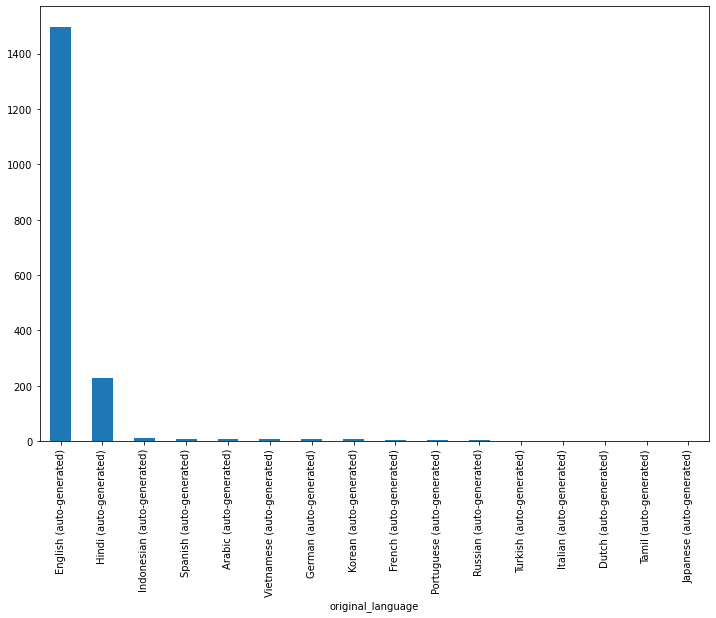

In [199]:
df_transcript = pd.read_csv('../data/raw_data/df_transcript_original_ai.csv')

plt.figure(figsize=(12,8))
df_transcript['original_language'].value_counts().plot(kind='bar')
plt.show();

# Get channel data

In [178]:
def get_channel_data(api_key, channel_id):
    url_channel = f'https://youtube.googleapis.com/youtube/v3/channels?part=snippet,contentDetails,statistics&id={channel_id}&key={api_key}'

    response = requests.get(url_channel).json()

    # Check if the response contains the channel data
    if 'items' in response and len(response['items']) > 0:
        item = response['items'][0]
        channel_data = {
            'channel_id': item['id'],
            'title': item['snippet']['title'],
            'description': item['snippet']['description'],
            'published_at': item['snippet']['publishedAt'],
            'subscriber_count': item['statistics'].get('subscriberCount'),
            'video_count': item['statistics'].get('videoCount'),
            'view_count': item['statistics'].get('viewCount')
        }
        if 'country' in item['snippet'].keys():
            channel_data['region'] = item['snippet']['country']
        else:
            channel_data['region'] = None
        return channel_data
    else:
        print("No channel data found.")
        return None

In [182]:
channel_id_list = set(df_video_ai['channelId'])

In [183]:
channel_data_list = [get_channel_data(api_key, id) for id in channel_id_list]

In [186]:
df_channel_data = pd.DataFrame(channel_data_list)
df_channel_data.to_csv('../data/raw_data/df_channel_data_ai.csv', index=False)

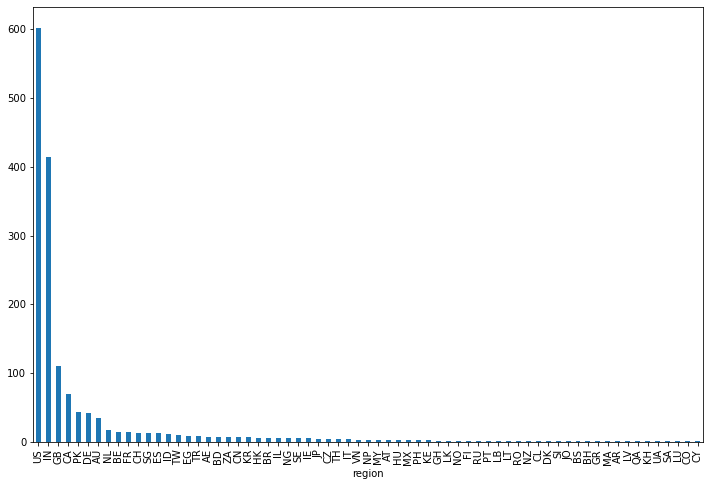

In [185]:
plt.figure(figsize=(12,8))
df_channel_data['region'].value_counts().plot(kind='bar')
plt.show();